# Whole brain data processing

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dir_root = '/nrs/ahrens/jing/giving_up/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/'
dask_tmp = '/opt/data/weiz/dask-worker-space'
memory_limit = 0 # unlimited

nsplit = (8, 16)

In [3]:
def check_demix_cells_layer(save_root, nlayer, nsplit = (10, 16)):
    import matplotlib.pyplot as plt
    Y_d_ave = da.from_zarr(f'{save_root}/Y_max.zarr')
    Y_d_ave_ = Y_d_ave.blocks[nlayer].squeeze().compute(scheduler='threads')
    v_max = np.percentile(Y_d_ave_, 99.9)
    
    list_ = ['_v1', '_v2', '_v3', '']
    len_list_ = len(list_)
    fig, ax = plt.subplots(1, len_list_+1, figsize=(4*(len_list_+1), 4))
    ax[0].imshow(Y_d_ave_, vmax=v_max)
    ax[0].axis('off')
    
    _, xdim, ydim, _ = Y_d_ave.shape
    _, x_, y_, _ = Y_d_ave.chunksize
    
    # for n_, ext in enumerate(list(['_v1', '_v2', '_v3', ''])):
    for n_, ext in enumerate(list_):
        A_mat = np.zeros((xdim, ydim))
        n_comp = 1
        for nx in range(nsplit[0]):
            for ny in range(nsplit[1]):
                try:
                    A_ = load_A_matrix(save_root=save_root, ext=ext, block_id=(nlayer, nx, ny, 0), min_size=0)
                except:
                    A_ = np.zeros((x_*y_,1))
#                 A_, A_ext = load_sup_A_matrix(save_root=save_root, ext=ext, block_id=(nlayer, nx, ny, 0), min_size=0)
                if (A_ is None) or (A_.size==0):
                    A_ = np.zeros((x_*y_,1))
#                 if (A_ext is None) or (A_ext.size==0):
#                     A_ext = np.zeros((x_*y_,1))
#                 A_ = np.concatenate((A_, A_ext), axis=-1)
                
                for n in range(A_.shape[-1]):
                    n_max = A_[:, n].max()
                    A_[A_[:,n]<n_max*0.1, n] = 0
                if A_.sum()==0:
                    continue
                A_comp = np.zeros(A_.shape[0])
                A_comp[A_.sum(axis=-1)>0] = np.argmax(A_[A_.sum(axis=-1)>0, :], axis=-1) + n_comp
                A_mat[x_*nx:x_*(nx+1), y_*ny:y_*(ny+1)] =A_comp.reshape(x_, y_, order='F')
                n_comp = A_mat.max()+1

        A_mat[A_mat>0] = A_mat[A_mat>0]%60+1
        ax[n_+1].imshow(A_mat, cmap=plt.cm.nipy_spectral_r, alpha=1.0)
        ax[n_+1].axis('off')

    plt.show()
    return None

0


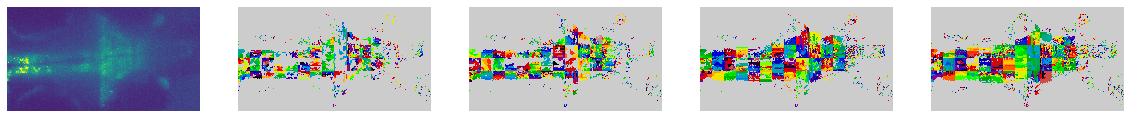

1


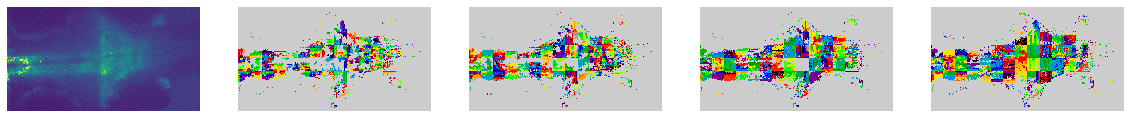

2


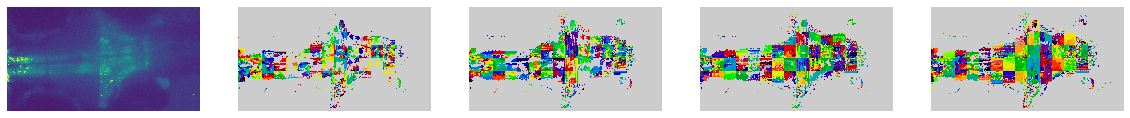

3


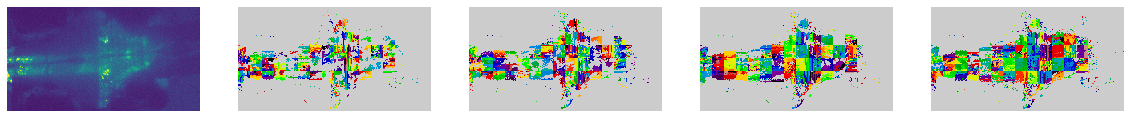

4


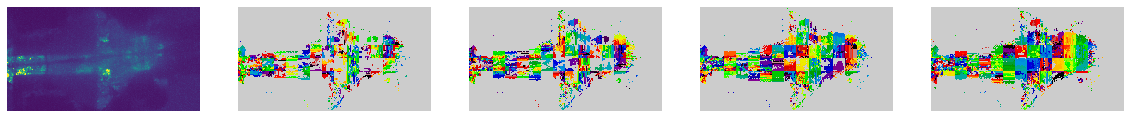

5


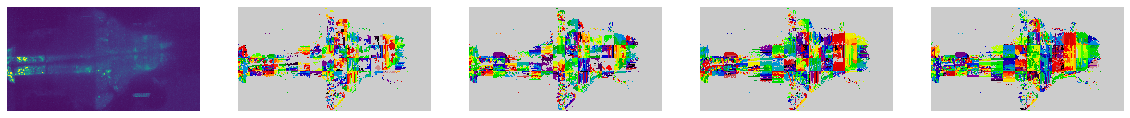

6


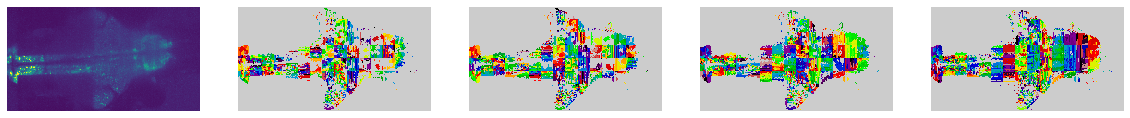

7


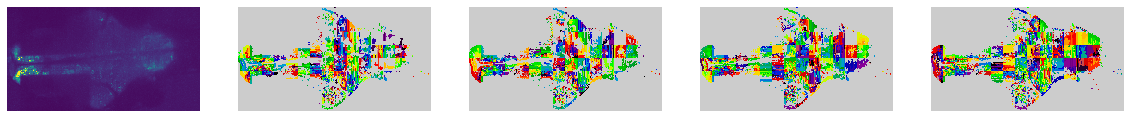

8


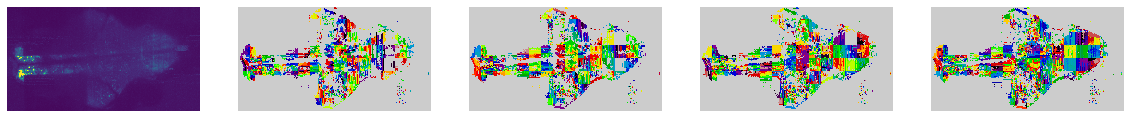

9


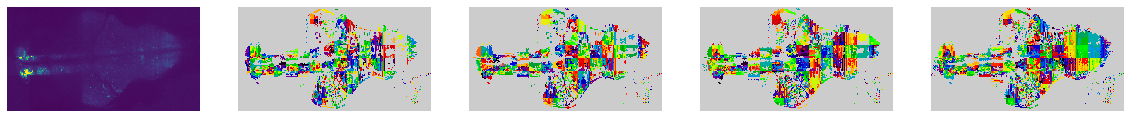

10


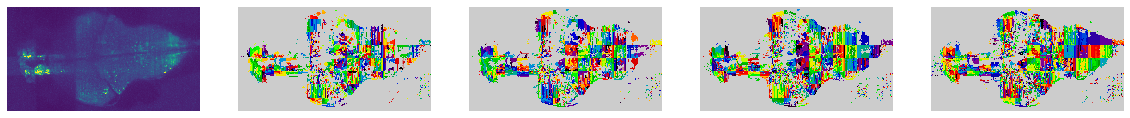

11


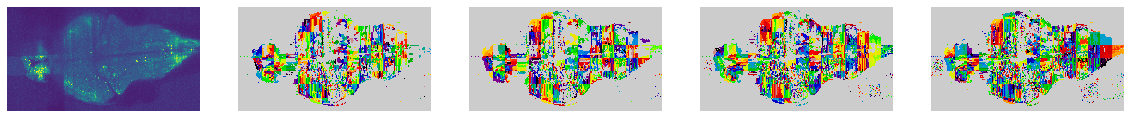

12


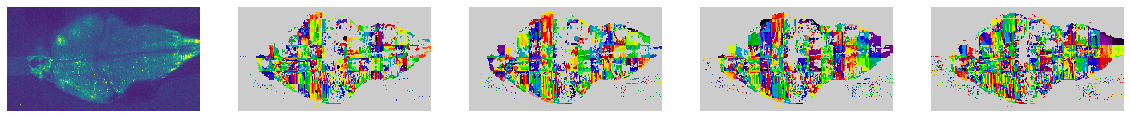

13


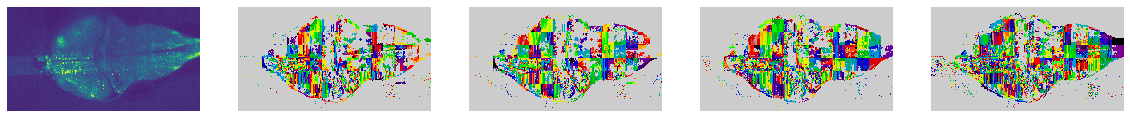

14


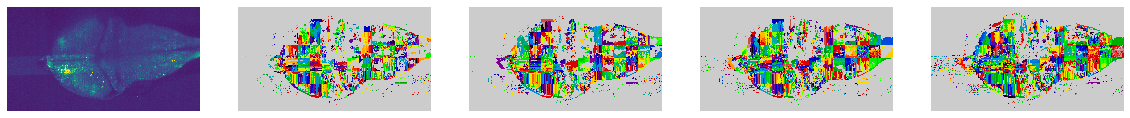

15


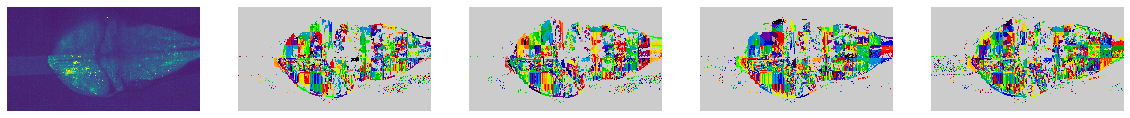

16


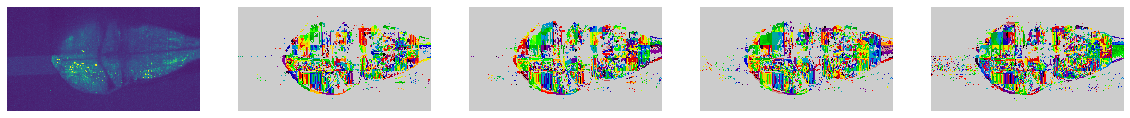

17


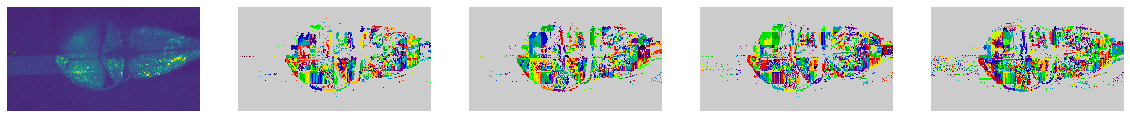

18


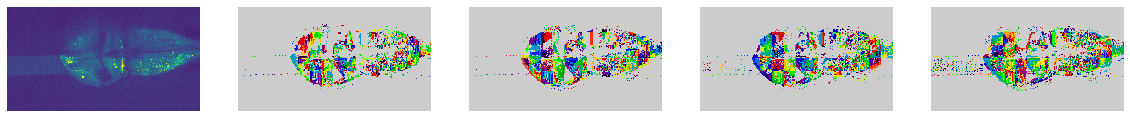

19


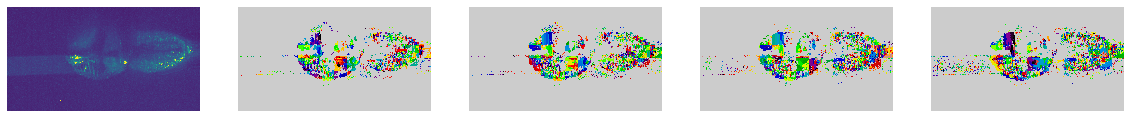

20


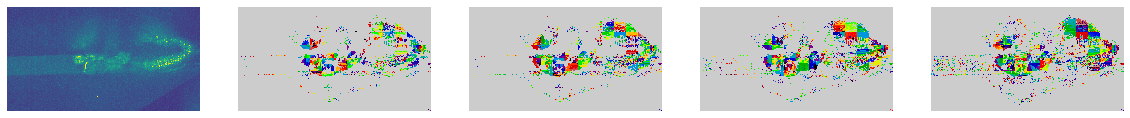

In [4]:
Y_d = zarr.open(f'{save_root}/Y_max.zarr', 'r')
mask = zarr.open(f'{save_root}/mask_map.zarr', 'r')
for n, n_ave_ in enumerate(Y_d):
    print(n)
    check_demix_cells_layer(save_root, n, nsplit = nsplit)

## df data after denoising

#### Take one block data for validation of denoise using local correlation

No components


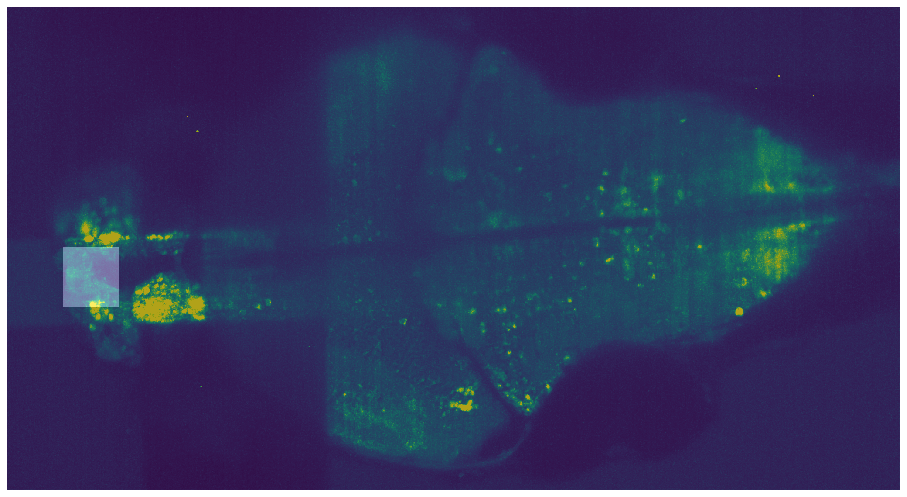

In [24]:
block_id = (10, 4, 1, 0)
check_demix_cells(save_root, block_id, plot_global=True, plot_mask=True)

In [27]:
from scipy.io import savemat
_ = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
_ = _.blocks[block_id]
savemat('tmp_dat_block.mat', {'neural_act':_})

In [26]:
_

dask.array<blocks, shape=(1, 138, 128, 10993), dtype=float32, chunksize=(1, 138, 128, 10993)>

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [10]:
# dff on raw data
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
baseline_t = da.map_blocks(baseline_from_Yd, trans_data_t, Y_d, dtype='float32')
_, nx, ny, _ = trans_data_t.chunksize
dff = Y_d/baseline_t

# dff on denoised data
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')
dff_ = (Y_svd+Y_d.mean(axis=-1, keepdims=True))/baseline_t

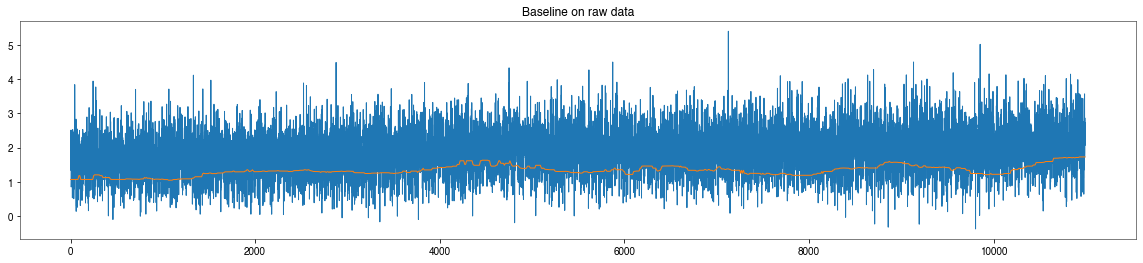

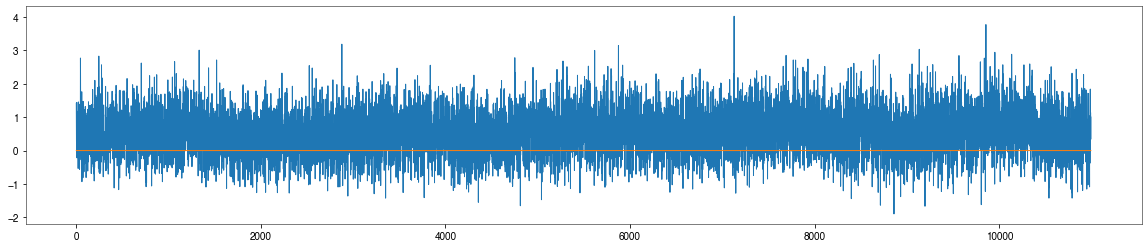

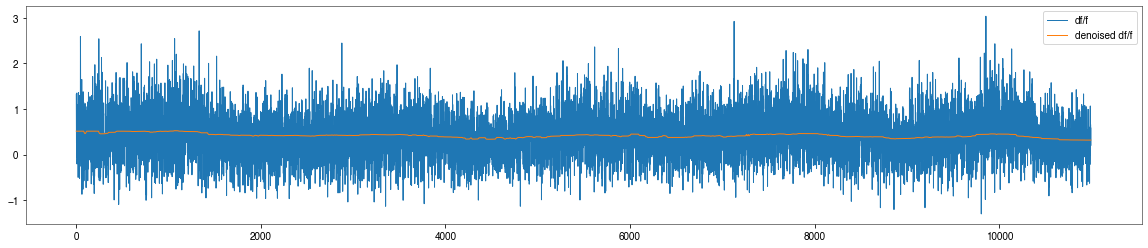

In [12]:
pix_id = (14, 500, 200)

plt.figure(figsize=(20, 4))
plt.plot(trans_data_t[pix_id])
plt.plot(baseline_t[pix_id])
# plt.ylim([0, 10])
plt.title('Baseline on raw data')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(Y_d[pix_id])
plt.plot(Y_svd[pix_id])
# plt.ylim([0, 10])
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(dff[pix_id], label='df/f')
plt.plot(dff_[pix_id], label='denoised df/f')
plt.legend()
# plt.ylim([0, 10])
plt.show()

### df/f on raw cell data

In [ ]:
compute_cell_dff_raw(save_root, dask_tmp=dask_tmp, memory_limit=0)

Scheduler: inproc://10.150.100.226/28860/90
Dashboard link: http://10.150.100.226/28860/90:38868/status
